In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import keras

from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout

np.set_printoptions(precision=4, suppress=True)

In [5]:
df = pd.read_csv('../datas.csv', sep=',', index_col='id')

subjects = ['calculus', 'algebra', 'discrete', 'ode', 'complex', 'programming',
            'stat', 'pde', 'functional', 'variational', 'random_proc', 'numerical']
years = [13, 14, 15, 16, 17]

df['course'] = [4] * 60 + [2] * 20 + [1] * 20
df['mean'] = df[subjects].mean(axis=1)
df['round'] = np.rint(df['mean'].values)

df.loc[df['year'] == 13, 'k'] = 0.8
df.loc[df['year'] == 14, 'k'] = 0.5
df.loc[df['year'] >= 15, 'k'] = 0.3

courses = {
    1: ['calculus', 'algebra', 'discrete'],
    2: ['ode', 'programming', 'complex'],
    3: ['stat', 'pde', 'functional'],
    4: ['variational', 'random_proc', 'numerical']
}

In [6]:
subject_courses = {
    1: ['calculus', 'algebra', 'discrete'],
    2: ['calculus', 'algebra', 'discrete', 'ode', 'complex', 'programming'],
    3: ['calculus', 'algebra', 'discrete', 'ode', 'complex', 'programming', 
        'stat', 'pde', 'functional'],
    4: ['calculus', 'algebra', 'discrete', 'ode', 'complex', 'programming', 
        'stat', 'pde', 'functional', 'variational', 'random_proc', 'numerical']
}

years = [13, 14, 15, 16, 17]
train_data = []


for index, row in df.iterrows():
    for i in range(1, 4):
        # [1] -> 2, [1,2] -> 3, [1, 2, 3] -> 4
        
        current_subjects = row[subject_courses[i]]
        if current_subjects.isnull().values.any():
            continue
        
        previous_mean = current_subjects.mean()
        next_subjects = row[subject_courses[i+1]]
        
        if next_subjects.isnull().values.any():
            continue
            
        next_mean = next_subjects.mean()

        train_data.append(dict(
            ege=row['ege'],
            k=row['k'],
            course=i,
            prev_mean=previous_mean,
            next_mean=next_mean,
            year=row['year']
        ))

train_df = pd.DataFrame(train_data)

x_train = train_df[['ege', 'k', 'prev_mean', 'course']].values
y_train = train_df['next_mean'].values

In [7]:
model = load_model('student_model.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 1)           1024      
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_______________________________________

### Прогнозирование для 2016 года 2 на  курс

20/20 [==============================] - 0s 4ms/step
[0.05084625631570816, 0.44999998807907104]


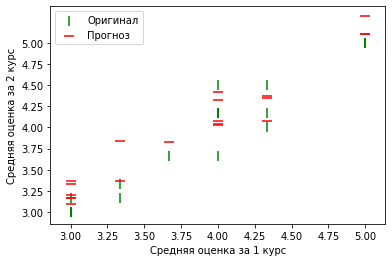

In [8]:
df_16 = train_df[train_df['year'] == 16][['ege', 'k', 'prev_mean', 'course', 'next_mean']]
x_test_16 = df_16[['ege', 'k', 'prev_mean', 'course']].values
y_test_16 = df_16['next_mean'].values

y_predict_16 = model.predict(x_test_16)

marker_size = [100 for i in range(len(x_test_16))]
plt.scatter(x_test_16[:, 2], y_test_16, marker='|', color='green', s=marker_size)
plt.scatter(x_test_16[:, 2], y_predict_16, marker='_', color='red', s=marker_size)

plt.legend(['Оригинал', 'Прогноз'])

plt.xticks(np.arange(3, 5.25, 0.25))
plt.yticks(np.arange(3, 5.25, 0.25))

plt.xlabel('Средняя оценка за 1 курс')
plt.ylabel('Средняя оценка за 2 курс')

plt.savefig('16_1_to_2.png', dpi=300)
loss_and_metrics = model.evaluate(x_test_16, y_test_16)
print(loss_and_metrics)

### Прогнозирование для 15 года на 4 курс

/home/roman/PycharmProjects/exam/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


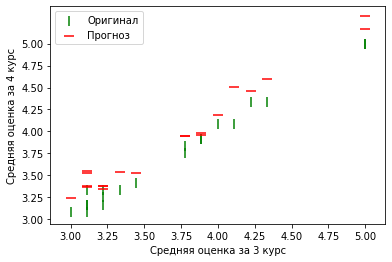

In [9]:
df_15 = train_df[train_df['year'] == 15][train_df['course']==3][['ege', 'k', 'prev_mean', 'course', 'next_mean']]
x_test_15 = df_15[['ege', 'k', 'prev_mean', 'course']].values
y_test_15 = df_15['next_mean'].values

y_predict_15 = model.predict(x_test_15)

marker_size = [100 for i in range(len(x_test_15))]
plt.scatter(x_test_15[:, 2], y_test_15, marker='|', color='green', s=marker_size)
plt.scatter(x_test_15[:, 2], y_predict_15, marker='_', color='red', s=marker_size)

plt.legend(['Оригинал', 'Прогноз'])
plt.xticks(np.arange(3, 5.25, 0.25))
plt.yticks(np.arange(3, 5.25, 0.25))
plt.xlabel('Средняя оценка за 3 курс')
plt.ylabel('Средняя оценка за 4 курс');

### Рекуррентное применение модели для прогноза средней успеваемости потоков

#### 2016 год. Предсказание с 3 по 4 курс

In [10]:
recurrent_series_16 = df.loc[df['year'] == 16, ['ege', 'k']].copy()
recurrent_series_16[1] = df.loc[df['year'] == 16, courses[1]].mean(axis=1)
recurrent_series_16[2] = df.loc[df['year'] == 16, courses[1] + courses[2]].mean(axis=1)

for i in range(2, 4):
    recurrent_series_16['course'] = i
    x = recurrent_series_16[['ege', 'k', i, 'course']].values
    y_predict = model.predict(x)
    recurrent_series_16[i+1] = y_predict

recurrent_series_16 = recurrent_series_16.drop(['ege', 'k', 'course'], axis=1)

#### Получившийся ряд предсказаний для 2016 года

In [11]:
recurrent_series_16

,1,2,3,4
id,,,,
61,5.000000,5.000000,5.120128,5.146311
62,5.000000,5.000000,5.128230,5.153949
63,5.000000,5.000000,5.327678,5.343698
64,4.000000,4.166667,4.074533,4.138565
65,4.000000,4.166667,4.360129,4.412592
66,4.333333,4.000000,4.126540,4.188340
67,4.000000,4.500000,4.454010,4.502928
68,4.333333,4.166667,4.414821,4.465211
69,4.333333,4.500000,4.389843,4.441176


#### Статистические параметры ряда разностей курсов (2-1, 3-2, 4-3, 4-2) для ряда предсказаний 2016 года

In [12]:
difference_series_16 = pd.DataFrame.from_dict({
    '2-1': recurrent_series_16[2] - recurrent_series_16[1],
    '3-2': recurrent_series_16[3] - recurrent_series_16[2],
    '4-3': recurrent_series_16[4] - recurrent_series_16[3],
    '4-2': recurrent_series_16[4] - recurrent_series_16[1],
})
difference_series_16.describe()

,2-1,3-2,4-3,4-2
count,20.000000,20.000000,20.000000,20.000000
mean,0.016667,0.167980,0.067233,0.251879
std,0.186535,0.183561,0.026382,0.233460
min,-0.333333,-0.123447,0.016020,-0.373975
25%,0.000000,0.078598,0.051098,0.144374
50%,0.000000,0.204663,0.065350,0.280153
75%,0.166667,0.254230,0.088881,0.387794
max,0.500000,0.555584,0.103958,0.622252


#### 2017 год. Предсказание с 2 по 4 курс

In [13]:
recurrent_series_17 = df.loc[df['year'] == 17, ['ege', 'k']].copy()
recurrent_series_17[1] = df.loc[df['year'] == 17, courses[1]].mean(axis=1)

for i in range(1, 4):
    recurrent_series_17['course'] = i
    x = recurrent_series_17[['ege', 'k', i, 'course']].values
    y_predict = model.predict(x)
    recurrent_series_17[i+1] = y_predict

recurrent_series_17 = recurrent_series_17.drop(['ege', 'k', 'course'], axis=1)

#### Получившийся ряд предсказаний для 2017 года

In [14]:
recurrent_series_17

,1,2,3,4
id,,,,
81,5.000000,4.992873,4.272102,4.327974
82,5.000000,4.941636,4.184319,4.243714
83,5.000000,4.926219,4.157661,4.218157
84,5.000000,5.097490,5.118482,5.144743
85,4.000000,4.077739,4.126540,4.188340
86,4.333333,4.415359,4.454010,4.502928
87,4.333333,4.330081,4.371180,4.423222
88,4.000000,3.905478,3.280103,3.377658
89,4.000000,3.839812,3.173551,3.277509


#### Статистические параметры ряда разностей курсов (2-1, 3-2, 4-3, 4-2) для ряда предсказаний 2017 года

In [15]:
difference_series_17 = pd.DataFrame.from_dict({
    '2-1': recurrent_series_17[2] - recurrent_series_17[1],
    '3-2': recurrent_series_17[3] - recurrent_series_17[2],
    '4-3': recurrent_series_17[4] - recurrent_series_17[3],
    '4-1': recurrent_series_17[4] - recurrent_series_17[1],
})
difference_series_17.describe()

,2-1,3-2,4-3,4-1
count,20.000000,20.000000,20.000000,20.000000
mean,0.121735,-0.174377,0.069334,0.016692
std,0.259005,0.355035,0.022694,0.533777
min,-0.190348,-0.768557,0.026261,-0.781843
25%,-0.078967,-0.635596,0.051980,-0.634763
50%,0.056689,0.040352,0.061148,0.157169
75%,0.344888,0.058518,0.088417,0.438468
max,0.727038,0.077515,0.103958,0.854387


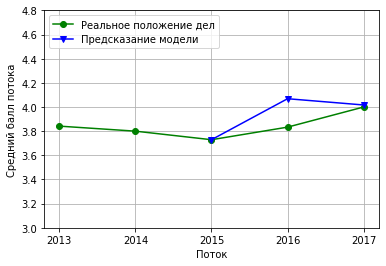

In [16]:
# real data
real_mean = {
    2013: df.loc[df['year'] == 13]['mean'].mean(),
    2014: df.loc[df['year'] == 14]['mean'].mean(),
    2015: df.loc[df['year'] == 15]['mean'].mean(),
    2016: df.loc[df['year'] == 16]['mean'].mean(),
    2017: df.loc[df['year'] == 17]['mean'].mean(),
}

x_real_mean = real_mean.keys()
y_real_mean = real_mean.values()

# model forecasting
model_mean = {
    2015: real_mean[2015],
    2016: recurrent_series_16[4].mean(),
    2017: recurrent_series_17[4].mean(),
}


x_model_mean = model_mean.keys()
y_model_mean = model_mean.values()

# pessimistic forecasting
pessimistic_df = df.copy()
pessimistic_df.loc[pessimistic_df['year'] == 16, courses[3] + courses[4]] = 3
pessimistic_df.loc[pessimistic_df['year'] == 17, courses[2] + courses[3] + courses[4]] = 3
pessimistic_df['mean'] = pessimistic_df[subjects].mean(axis=1)

pessemistic_mean_by_flow = {
    2015: pessimistic_df.loc[pessimistic_df['year'] == 15]['mean'].mean(),
    2016: pessimistic_df.loc[pessimistic_df['year'] == 16]['mean'].mean(),
    2017: pessimistic_df.loc[pessimistic_df['year'] == 17]['mean'].mean(),
}

x_pess_mean = pessemistic_mean_by_flow.keys()
y_pess_mean = pessemistic_mean_by_flow.values()

plt.errorbar(x_real_mean, y_real_mean, marker='o', color='green')
plt.errorbar(x_model_mean, y_model_mean, marker='v', color='blue')
# plt.errorbar(x_pess_mean, y_pess_mean, marker='s', color='green')

plt.ylabel('Средний балл потока')
plt.xlabel('Поток')

plt.legend(['Реальное положение дел', 'Предсказание модели', 'Пессимистичный прогноз'], loc=2)
plt.xticks(np.arange(2013, 2017+1, 1))
plt.yticks(np.arange(3, 5, 0.2))
plt.grid()
plt.savefig('mean_by_flow_with_prediction.png', dpi=300)

### Средняя оценка для потока 2016 года на 2 курс

In [17]:
df.loc[df['year'] == 16, courses[1] + courses[2]].mean(axis=1).mean()

3.833333333333333

### Средняя оценка для потока 2016 года на 1 курс

In [18]:
df.loc[df['year'] == 16, courses[1]].mean(axis=1).mean()

3.8166666666666664

### Средняя оценка для потока 2017 года на 1 курс

In [19]:
df.loc[df['year'] == 17, courses[1]].mean(axis=1).mean()

4.0